In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [4]:
returns = pd.read_pickle("../Data/returns.pkl")
returns = returns.iloc[1:]

In [5]:
# dropping columns with all NaN
drop_columns = []

for col in returns.columns:
    if returns[col].isnull().all() == True:
        drop_columns.append(col)
        
returns.drop(columns=drop_columns, inplace=True)

In [6]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = returns.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [7]:
def format_investable(df, n_in=1, n_out=1):
    "Takes investable dataframe and formats it to have all stock returns at time t-1\
    (the features) and all corresponding stock returns at time t (the targets)\
    n_in is the number of past returns we want to use, n_out is the number of future \
    returns we want to predict"
    
    n_vars = df.shape[1]
    
    cols = []
    input_col_names = df.add_suffix(' (t-1)').columns
    forecast_col_names = df.add_suffix(' (t)').columns
    names = input_col_names.append(forecast_col_names)
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop the first row (it contains NaNs)
    agg.dropna(inplace=True)
    
    return agg

In [8]:
def reshape_investable(df):
    "Takes formatted investable and reshapes inputs it into 3D array [samples, timesteps, features]"
    
    # select columns ending with ' (t-1)' for features
    # and columns ending with ' (t)' for targets
    X_col = [df.columns[i] for i in range(df.shape[1]) if df.columns[i].endswith(' (t-1)')]
    y_col = [df.columns[i] for i in range(df.shape[1]) if df.columns[i].endswith(' (t)')]

    X_train = df[X_col].iloc[1:,:].values
    y_train = df[y_col].iloc[1:,:].values
    
    X_test = df[X_col].iloc[0:1,:].values
    y_test = df[y_col].iloc[0:1,:].values
    
    #reshape
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    return X_train, y_train, X_test, y_test

In [21]:
def portfolio_return(df, n):
    "Takes dataframe with predicted and actual returns and outputs and what the equally-weighted\
    portfolio with n long and n short stocks would have actually earned"
    pred = df.sort_values(by = 'pred return', ascending = False)
    topn_p = pred.head(n)
    botn_p = pred.tail(n)
    return_a = topn_p['actual return'].mean() - botn_p['actual return'].mean()
    #return_long = topn_p['actual return'].sum()
    #return_short = botn_p['actual return'].sum()
    
    return return_a #, return_long, return_short

In [10]:
def topn_bottomn(df, n):
    "Takes dataframe with predicted and actual returns and outputs a list of predicted top n\
    stocks and another list of bottom n stocks"
    pred = df.sort_values(by = 'pred return', ascending = False)
    topn_p = pred.head(n)
    botn_p = pred.tail(n)
    return topn_p, botn_p

In [17]:
def LSTM_pipeline(n_stocks, lookback):
    #dataframe to collect portfolio returns at all t
    all_returns = pd.DataFrame(columns = ['date', 'portfolio return'])
    
    date_range = returns.index[2527:2652]
    
    all_returns['date'] = date_range
    all_returns['date'] = all_returns['date'].astype('datetime64[ns]')
    all_returns.set_index('date', inplace = True)
    
    count = 0
    for t in date_range:
        t = pd.to_datetime(t)
        
        #get investable
        investable = get_investable(t, lookback)
        #format as features and targets
        f_investable = format_investable(investable)
        #get train, test sets
        X_train, y_train, X_test, y_test = reshape_investable(f_investable)

        #create model
        model = Sequential()
        model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(y_train.shape[1]))

        #compile and fit model
        model.compile(loss = 'mae', optimizer = 'adam')
        history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose = 0)

        #predict
        yhat = model.predict(X_test, verbose = 0)

        #format predictions and actual returns in dataframe
        col = [f_investable.columns[i] for i in range(f_investable.shape[1]) if f_investable.columns[i].endswith(' (t)')]
        df = pd.DataFrame(index = col, data = yhat.T)
        df = df.rename(columns = {0: 'pred return'})
        df['actual return'] = y_test.T

        #calculate portfolio return
        return_t = portfolio_return(df, 5)

        #add return to dataframe
        all_returns.loc[t]['portfolio return'] = return_t
        
        count+=1
        print(f'{len(date_range) - count} time periods remaining...')
    
    all_returns['portfolio return'] = all_returns['portfolio return'].astype(float)
    
    return all_returns

## 125 time periods from 2000-01-03 to 2000-06-30

In [22]:
df = LSTM_pipeline(5, 504)

124 time periods remaining...
123 time periods remaining...
122 time periods remaining...
121 time periods remaining...
120 time periods remaining...
119 time periods remaining...
118 time periods remaining...
117 time periods remaining...
116 time periods remaining...
115 time periods remaining...
114 time periods remaining...
113 time periods remaining...
112 time periods remaining...
111 time periods remaining...
110 time periods remaining...
109 time periods remaining...
108 time periods remaining...
107 time periods remaining...
106 time periods remaining...
105 time periods remaining...
104 time periods remaining...
103 time periods remaining...
102 time periods remaining...
101 time periods remaining...
100 time periods remaining...
99 time periods remaining...
98 time periods remaining...
97 time periods remaining...
96 time periods remaining...
95 time periods remaining...
94 time periods remaining...
93 time periods remaining...
92 time periods remaining...
91 time periods re

In [56]:
df

,portfolio return
date,
2000-01-03,11.7164
2000-01-04,-0.33706
2000-01-05,32.16
2000-01-06,1.97458
2000-01-07,-42.6359
...,...
2000-06-26,6.00099
2000-06-27,-20.0418
2000-06-28,23.3572


In [62]:
df['portfolio return'] = df['portfolio return'].astype(float)

In [182]:
monthly_avg = df.resample('M').mean()
monthly_avg

,portfolio return
date,
2000-01-31,6.706479
2000-02-29,6.374764
2000-03-31,0.641600
2000-04-30,19.073776
2000-05-31,9.030674
2000-06-30,15.758259


In [225]:
total_avg = df['portfolio return'].mean()
print(f'Total average return is: {total_avg:.2f} %')

Total average return is: 9.40 %


In [229]:
data = df.copy(deep = True)
data['30_day_avg'] = data['portfolio return'].rolling(30).mean()
data.dropna(inplace = True)

In [230]:
data

,portfolio return,30_day_avg
date,,
2000-02-14,-28.306317,5.238465
2000-02-15,8.987185,5.147492
2000-02-16,16.028645,5.693015
2000-02-17,7.626743,4.875239
2000-02-18,37.318598,6.053373
...,...,...
2000-06-26,6.000989,13.283312
2000-06-27,-20.041834,12.820965
2000-06-28,23.357208,13.280555


In [131]:
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import matplotlib.ticker as ticker

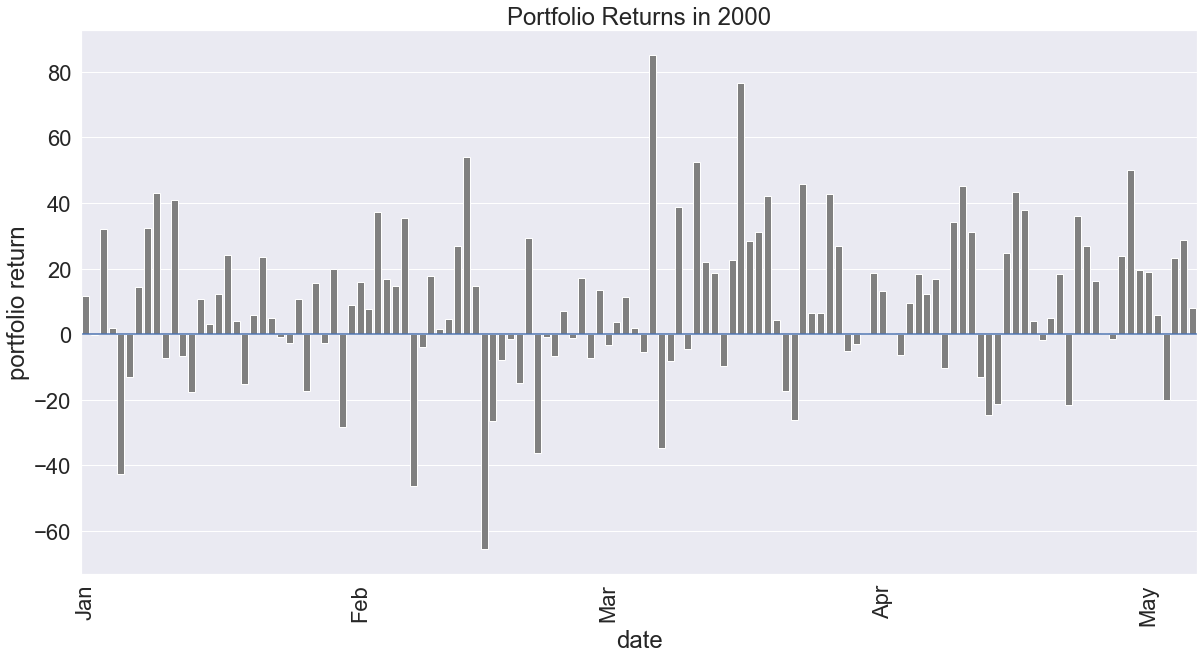

In [150]:
fig, axes = plt.subplots(figsize=(20,10))
sns.barplot(x = 'date', y = 'portfolio return', data = data, color = 'grey')

axes.xaxis.set_major_locator(mdates.MonthLocator())
myFmt = mdates.DateFormatter("%b")
axes.xaxis.set_major_formatter(myFmt)
#axes.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

plt.xticks(rotation = 'vertical')
axes.set_title('Portfolio Returns in 2000')

sns.set(font_scale=2)
plt.axhline(0)

plt.show()

## Comparison to S&P

In [160]:
sp_actual = pd.read_csv('./Data/S&P 500 Historical Data (3).csv', usecols = ['Date', 'Change %'], index_col = 'Date', parse_dates = True)

In [161]:
sp_actual

,Change %
Date,
Dec-00,0.41%
Nov-00,-8.01%
Oct-00,-0.49%
Sep-00,-5.35%
Aug-00,6.07%
Jul-00,-1.63%
Jun-00,2.39%
May-00,-2.19%
Apr-00,-3.08%


In [183]:
monthly_avg.index = monthly_avg.index.strftime('%b-%y')
monthly_avg

,portfolio return
date,
Jan-00,6.706479
Feb-00,6.374764
Mar-00,0.641600
Apr-00,19.073776
May-00,9.030674
Jun-00,15.758259


In [194]:
strategy_vs_sp = monthly_avg.merge(sp_actual, left_index = True, right_index = True)
strategy_vs_sp['Change %'] = strategy_vs_sp['Change %'].apply(lambda x: x.strip('%'))

In [197]:
strategy_vs_sp['Change %'] = strategy_vs_sp['Change %'].astype(float)
strategy_vs_sp = strategy_vs_sp.rename(columns = {'Change %': 's&p return'})

In [198]:
strategy_vs_sp

,portfolio return,s&p return
Jan-00,6.706479,-5.09
Feb-00,6.374764,-2.01
Mar-00,0.641600,9.67
Apr-00,19.073776,-3.08
May-00,9.030674,-2.19
Jun-00,15.758259,2.39


<AxesSubplot:xlabel='Date', ylabel='Return (%)'>

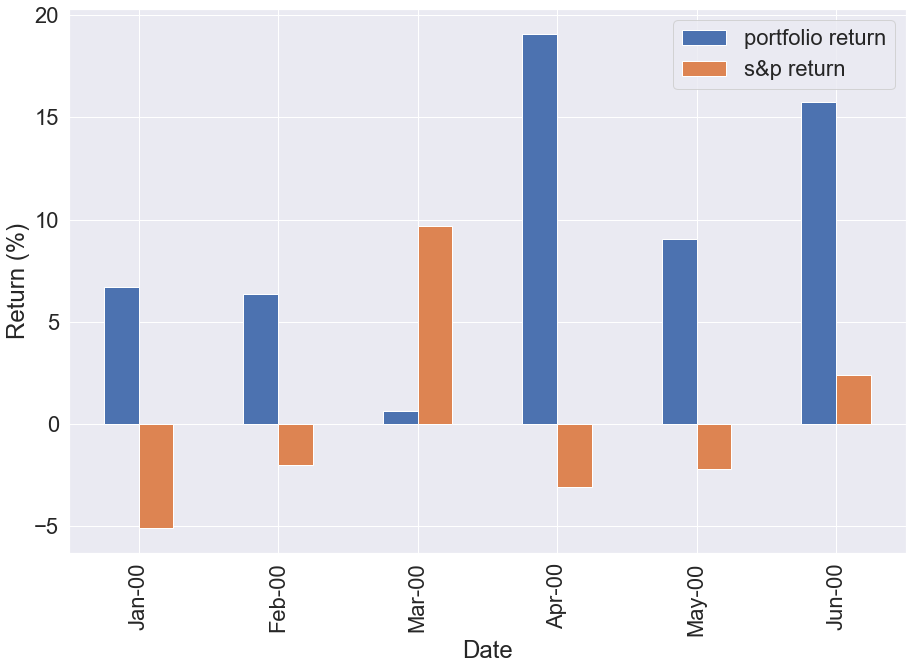

In [222]:
strategy_vs_sp.plot(kind = 'bar', xlabel = 'Date', ylabel = 'Return (%)', figsize=(15,10))

## Comparison to Simple RNN

In [255]:
def LSTM_pipeline_comp(n_stocks, lookback):
    #dataframe to collect portfolio returns at all t
    all_returns = pd.DataFrame(columns = ['date', 'portfolio return'])
    
    date_range = returns.index[7888:7911]
    
    all_returns['date'] = date_range
    all_returns['date'] = all_returns['date'].astype('datetime64[ns]')
    all_returns.set_index('date', inplace = True)
    
    count = 0
    for t in date_range:
        t = pd.to_datetime(t)
        
        #get investable
        investable = get_investable(t, lookback)
        #format as features and targets
        f_investable = format_investable(investable)
        #get train, test sets
        X_train, y_train, X_test, y_test = reshape_investable(f_investable)

        #create model
        model = Sequential()
        model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(y_train.shape[1]))

        #compile and fit model
        model.compile(loss = 'mae', optimizer = 'adam')
        history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose = 0)

        #predict
        yhat = model.predict(X_test, verbose = 0)

        #format predictions and actual returns in dataframe
        col = [f_investable.columns[i] for i in range(f_investable.shape[1]) if f_investable.columns[i].endswith(' (t)')]
        df = pd.DataFrame(index = col, data = yhat.T)
        df = df.rename(columns = {0: 'pred return'})
        df['actual return'] = y_test.T

        #calculate portfolio return
        return_t = portfolio_return(df, 5)

        #add return to dataframe
        all_returns.loc[t]['portfolio return'] = return_t
        
        count+=1
        print(f'{len(date_range) - count} time periods remaining...')
    
    all_returns['portfolio return'] = all_returns['portfolio return'].astype(float)
    
    return all_returns

In [256]:
df_rnn = LSTM_pipeline_comp(5,160)

22 time periods remaining...
21 time periods remaining...
20 time periods remaining...
19 time periods remaining...
18 time periods remaining...
17 time periods remaining...
16 time periods remaining...
15 time periods remaining...
14 time periods remaining...
13 time periods remaining...
12 time periods remaining...
11 time periods remaining...
10 time periods remaining...
9 time periods remaining...
8 time periods remaining...
7 time periods remaining...
6 time periods remaining...
5 time periods remaining...
4 time periods remaining...
3 time periods remaining...
2 time periods remaining...
1 time periods remaining...
0 time periods remaining...


In [259]:
df_rnn['portfolio return'] = df_rnn['portfolio return'].astype(float)

In [258]:
monthly_avg_rnn = df_rnn.resample('M').mean()
monthly_avg_rnn

,portfolio return
date,
2021-04-30,-0.523440
2021-05-31,4.896529


In [257]:
total_avg = df_rnn['portfolio return'].mean()
print(f'Total average return is: {total_avg:.2f} %')

Total average return is: 3.72 %


## All time periods

In [19]:
def LSTM_pipeline_all(n_stocks, lookback):
    #dataframe to collect portfolio returns at all t
    all_returns = pd.DataFrame(columns = ['date', 'portfolio return'])
    
    date_range = returns.index[2527:7912]
    
    all_returns['date'] = date_range
    all_returns['date'] = all_returns['date'].astype('datetime64[ns]')
    all_returns.set_index('date', inplace = True)
    
    count = 0
    for t in date_range:
        t = pd.to_datetime(t)
        
        #get investable
        investable = get_investable(t, lookback)
        #format as features and targets
        f_investable = format_investable(investable)
        #get train, test sets
        X_train, y_train, X_test, y_test = reshape_investable(f_investable)

        #create model
        model = Sequential()
        model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(y_train.shape[1]))

        #compile and fit model
        model.compile(loss = 'mae', optimizer = 'adam')
        history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose = 0)

        #predict
        yhat = model.predict(X_test, verbose = 0)

        #format predictions and actual returns in dataframe
        col = [f_investable.columns[i] for i in range(f_investable.shape[1]) if f_investable.columns[i].endswith(' (t)')]
        df = pd.DataFrame(index = col, data = yhat.T)
        df = df.rename(columns = {0: 'pred return'})
        df['actual return'] = y_test.T

        #calculate portfolio return
        return_t = portfolio_return(df, 5)

        #add return to dataframe
        all_returns.loc[t]['portfolio return'] = return_t
        
        count+=1
        print(f'{len(date_range) - count} time periods remaining...')
    
    all_returns['portfolio return'] = all_returns['portfolio return'].astype(float)
    
    return all_returns

In [20]:
%%timeit
df_all = LSTM_pipeline_all(5, 504)

5384 time periods remaining...
5383 time periods remaining...
5382 time periods remaining...
5381 time periods remaining...
5380 time periods remaining...
5379 time periods remaining...
5378 time periods remaining...
5377 time periods remaining...
5376 time periods remaining...
5375 time periods remaining...
5374 time periods remaining...
5373 time periods remaining...
5372 time periods remaining...
5371 time periods remaining...
5370 time periods remaining...
5369 time periods remaining...
5368 time periods remaining...
5367 time periods remaining...
5366 time periods remaining...
5365 time periods remaining...
5364 time periods remaining...
5363 time periods remaining...
5362 time periods remaining...
5361 time periods remaining...
5360 time periods remaining...
5359 time periods remaining...
5358 time periods remaining...
5357 time periods remaining...
5356 time periods remaining...
5355 time periods remaining...
5354 time periods remaining...
5353 time periods remaining...
5352 tim

5119 time periods remaining...
5118 time periods remaining...
5117 time periods remaining...
5116 time periods remaining...
5115 time periods remaining...
5114 time periods remaining...
5113 time periods remaining...
5112 time periods remaining...
5111 time periods remaining...
5110 time periods remaining...
5109 time periods remaining...
5108 time periods remaining...
5107 time periods remaining...
5106 time periods remaining...
5105 time periods remaining...
5104 time periods remaining...
5103 time periods remaining...
5102 time periods remaining...
5101 time periods remaining...
5100 time periods remaining...
5099 time periods remaining...
5098 time periods remaining...
5097 time periods remaining...
5096 time periods remaining...
5095 time periods remaining...
5094 time periods remaining...
5093 time periods remaining...
5092 time periods remaining...
5091 time periods remaining...
5090 time periods remaining...
5089 time periods remaining...
5088 time periods remaining...
5087 tim

KeyboardInterrupt: 